In [1]:
import os.path as osp
import pyrootutils

pyrootutils.setup_root(
    search_from=osp.abspath(''),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,  # add to system path
    dotenv=True,      # load environment variables .env file
    cwd=True,         # change cwd to root
)

PosixPath('/Users/mlle/Repos/grow-ai/rise-gen')

In [2]:
import torch
import matplotlib.pyplot as plt

from model.vae.vnca import VNCA
from model.vae.star_vae import StarVAE
from sim.builder import SimBuilder
import utils.plot as viz

torch.autograd.set_grad_enabled(False);

In [3]:
vnca = VNCA.load_from_checkpoint('data/ckpt/vnca/v2-epoch=58-val_loss=0.561.ckpt').eval()
vae = StarVAE.load_from_checkpoint('data/ckpt/vae/downloaded.ckpt').eval()

In [4]:
VOXEL_SIZE, MAX_TORQUE = 0.01, 6

def build_robot(voxels):
    builder = SimBuilder(
            voxel_size=VOXEL_SIZE,
            valid_min_rigid_ratio=0.2,
            valid_min_joint_num=2,
            valid_max_connected_components=1,
            min_rigid_volume=100,
            hinge_torque=MAX_TORQUE,
        )
    
    builder.build(
        voxels,
        save_history=False,
        save_h5_history=False,
        print_summary=True
    )

    return builder

def viz_robot(robot):
    fig = plt.figure(figsize=(18, 6))
    axs = fig.subplots(1, 3, subplot_kw={"projection": "3d"})

    robot.visualize(
        is_not_empty_ax=axs[0],
        is_rigid_ax=axs[1],
        segmentation_ax=axs[2],
    )

    return fig

def generate_robots(vnca, n):
    return vnca.get_samples(n)  

# Plotting examples

In [5]:
TOTAL_ROBOTS = 10

voxel_logits = generate_robots(vnca, TOTAL_ROBOTS)
example_robots = [build_robot(vl) for vl in voxel_logits]

[robot] Voxel num: 4553 rigid segment num: 3 joint num: 2
[robot] Build failed, invalid reason: Below min rigid ratio 0.2, Ratio: 0.17699182644564967
[robot] Build failed, invalid reason: Below min rigid ratio 0.2, Ratio: 0.12139630848157029
[robot] Voxel num: 24225 rigid segment num: 4 joint num: 3
[robot] Voxel num: 22810 rigid segment num: 5 joint num: 4
[robot] Build failed, invalid reason: Below min rigid ratio 0.2, Ratio: 0.13608419297697197
[robot] Voxel num: 15862 rigid segment num: 3 joint num: 2
[robot] Build failed, invalid reason: Below min rigid ratio 0.2, Ratio: 0.130298273155416
[robot] Voxel num: 19243 rigid segment num: 4 joint num: 3
[robot] Build failed, invalid reason: Below min rigid ratio 0.2, Ratio: 0.1733207738569669


In [6]:
valid = list(map(lambda x: x.log['is_valid'], example_robots))
valid_idx = [i for i, x in enumerate(valid) if x]
print(valid)
print(valid_idx)

[True, False, False, True, True, False, True, False, True, False]
[0, 3, 4, 6, 8]


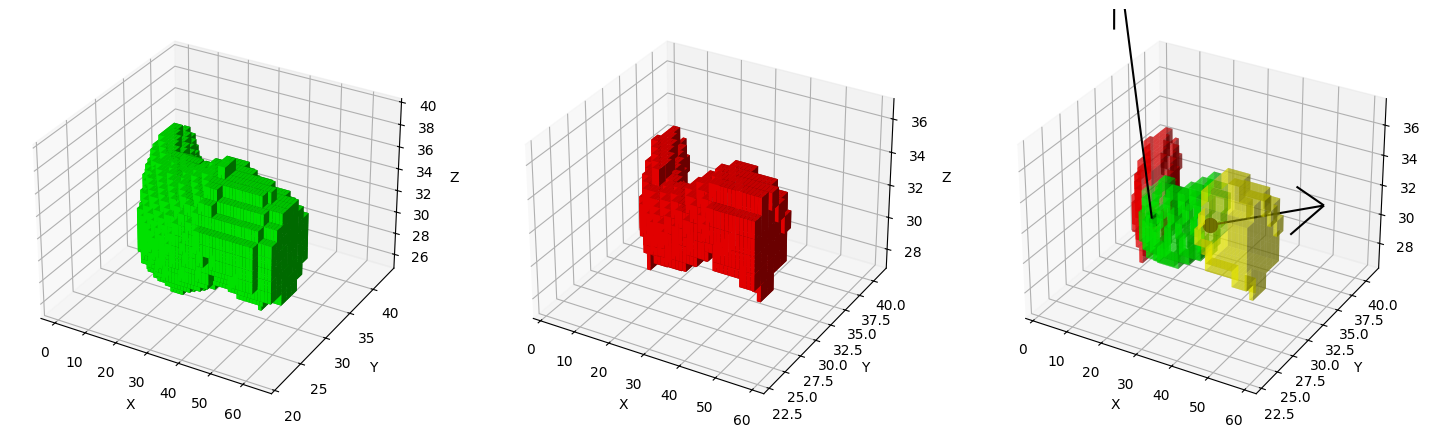

In [14]:
viz_robot(example_robots[valid_idx[0]]);

# Reconstructing

In [8]:
x = voxel_logits[valid_idx]

# VAE baseline
vae_recons = vae.forward(x)
vae_recons = [build_robot(x) for x in vae_recons]

# VNCA
vnca_recons = vnca.forward(x)[0]
vnca_robots = [build_robot(x) for x in vnca_recons]

[robot] Voxel num: 5090 rigid segment num: 3 joint num: 2
[robot] Voxel num: 28526 rigid segment num: 4 joint num: 3
[robot] Voxel num: 24394 rigid segment num: 5 joint num: 4
[robot] Voxel num: 18401 rigid segment num: 3 joint num: 2
[robot] Voxel num: 22776 rigid segment num: 4 joint num: 3
[robot] Voxel num: 9444 rigid segment num: 3 joint num: 2
[robot] Voxel num: 42223 rigid segment num: 4 joint num: 3
[robot] Voxel num: 38773 rigid segment num: 3 joint num: 2
[robot] Voxel num: 19027 rigid segment num: 3 joint num: 2
[robot] Voxel num: 30445 rigid segment num: 4 joint num: 3


## Plotting VAE reconstructions

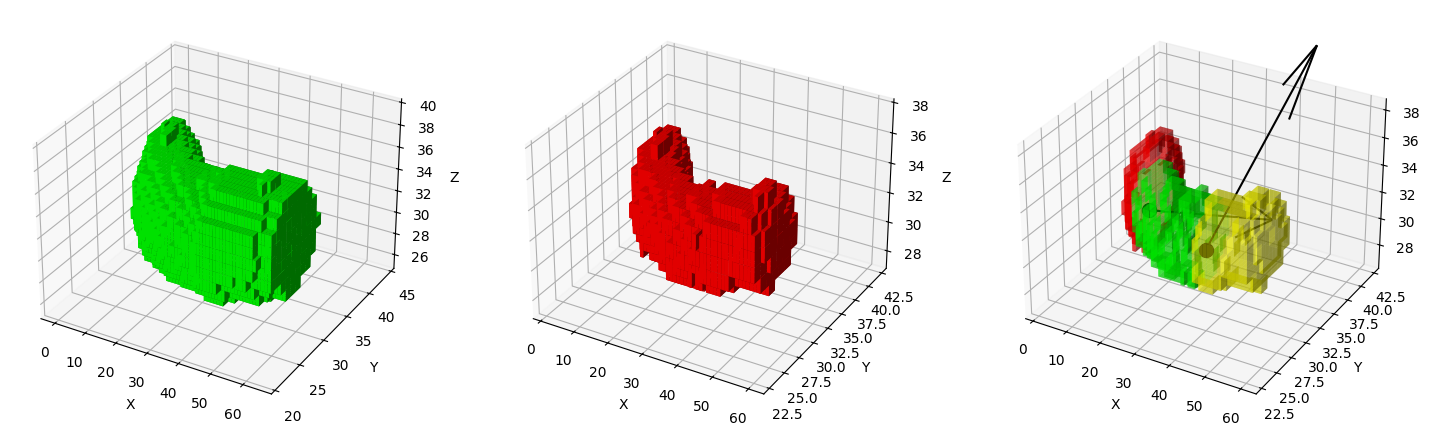

In [15]:
viz_robot(vae_recons[0]);

## Plotting VNCA reconstructions

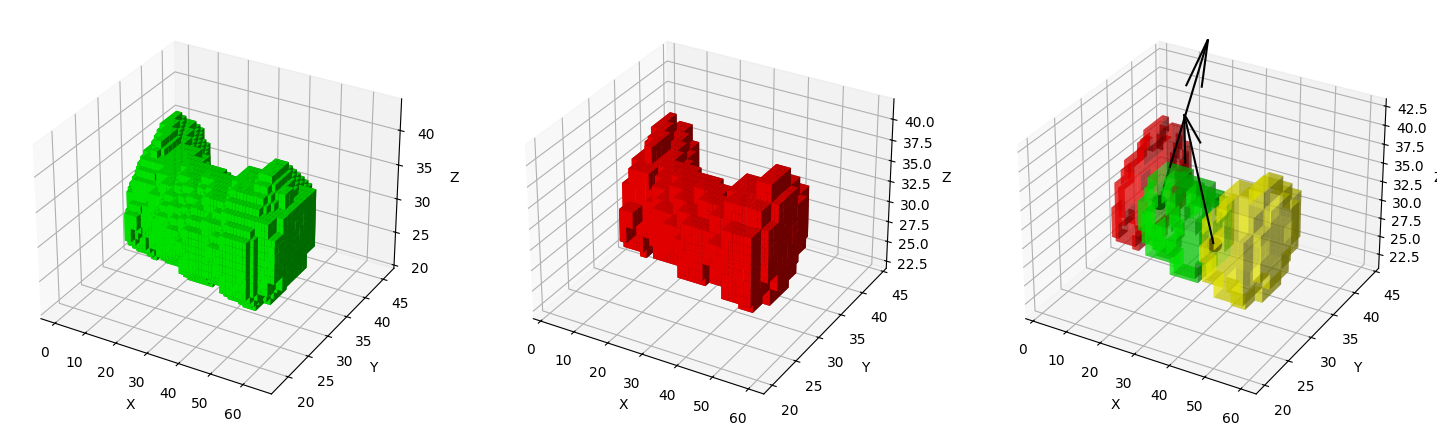

In [16]:
viz_robot(vnca_robots[0]);

In [18]:
vnca.hparams
print(vnca.decoder)

NCADecoder(
  (nca): NCA(
    (update_net): Sequential(
      (0): Conv3d(512, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): Residual(
        (0): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (1): ELU(alpha=1.0)
        (2): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      )
      (2): Residual(
        (0): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (1): ELU(alpha=1.0)
        (2): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      )
      (3): Residual(
        (0): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (1): ELU(alpha=1.0)
        (2): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      )
      (4): Residual(
        (0): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (1): ELU(alpha=1.0)
        (2): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      )
      (5): Conv3d(128, 512, kernel_size=(1, 1, 1), stride=(1